# **Selección del modelo y ajuste de hiperparámetros**

En este capítulo se llevará a cabo el proceso de selección del modelo de aprendizaje automático más adecuado para la detección del riesgo de diabetes, a partir de la comparación del desempeño de distintos algoritmos de clasificación. La evaluación se realizará considerando métricas relevantes para problemas de clases desbalanceadas, poniendo especial énfasis en la métrica recall, debido a la importancia de identificar correctamente a los pacientes con alto riesgo de diabetes.

Posteriormente, se procederá a la optimización de hiperparámetros del modelo que presente el mejor equilibrio entre desempeño y estabilidad, con el objetivo de mejorar su capacidad de generalización y evitar posibles problemas de sobreajuste. Este ajuste permitirá refinar el comportamiento del modelo ganador y maximizar su desempeño en ambas clases.

Finalmente, se analizará el impacto de las variables más relevantes para el modelo seleccionado, con el fin de interpretar qué características clínicas influyen en mayor medida en la predicción del riesgo de diabetes. Este análisis busca aportar interpretabilidad al modelo, facilitando la comprensión de los resultados y su posible aplicación en un contexto clínico.

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import warnings

In [ ]:
warnings.filterwarnings('ignore')

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/dataset/Diabetes_Mexico_clean.csv')

In [ ]:
X = df.drop('riesgo_diabetes_cat',axis = 1)
y = df['riesgo_diabetes_cat']

## **Partición del conjunto de datos**

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.2,random_state =42)

In [ ]:
X_train.shape[0],X_test.shape[0]

(2026, 507)

| Subconjunto       | Proporción | Observaciones |
| ----------------- | ---------- | ------------- |
| **Entrenamiento** | 80%        | 2,026         |
| **Prueba**        | 20%        | 507           |



El conjunto de prueba se mantuvo estrictamente aislado durante todo el proceso de modelado para evitar data leakage y obtener una estimación insesgada del error de generalización. La partición se ejecutó mediante train_test_split con random_state fijado para garantizar reproducibilidad.



La dimensionalidad del dataset (n = 2,533 observaciones totales) impone restricciones significativas sobre la complejidad del modelo candidato. Específicamente, se descartó la implementación de redes neuronales profundas por las siguientes razones:

* Riesgo de sobreajuste severo: Arquitecturas con alto número de parámetros  sobreajustan datasets pequeños, memorizando el ruido en lugar de aprender patrones generalizables.

* Ineficiencia muestral: Las redes neuronales requieren típicamente órdenes grandes para converger a representaciones robustas, especialmente en problemas tabulares.

Alternativas más apropiadas: Para este volumen de datos, se priorizaron modelos con mayor eficiencia muestral e interpretabilidad:

* **Regresión logística**
* **Random Forest**
* **Gradient Boosting**
* **SVC**
* **KNN**

In [ ]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import PowerTransformer,OneHotEncoder

In [ ]:
num_features = X_train.select_dtypes('float64').columns
cat_features = X_train.select_dtypes('object').columns


preprocessor = ColumnTransformer(
    transformers=[
        ('num', PowerTransformer(), num_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), cat_features)
    ]
)

Dado que modelos como SVC, regresión logística y k-NN son altamente sensibles a la escala y distribución de las variables, se definió un objeto de preprocesamiento específico denominado preprocessor. Este objeto aplica transformaciones de potencia mediante PowerTransformer (método Yeo–Johnson) sobre las variables numéricas continuas, con el objetivo de reducir la asimetría, mitigar el efecto de valores atípicos y llevar las variables a una escala comparable.

La aplicación de este preprocesador permite mejorar la estabilidad numérica y el desempeño de modelos basados en distancias o fronteras de decisión, garantizando además que el mismo esquema de transformación se aplique de forma consistente tanto en el conjunto de entrenamiento como en el de prueba, evitando así problemas de fuga de información.

## **Modelos**

In [ ]:
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline

In [ ]:
svc = SVC(random_state = 42,kernel="linear",class_weight="balanced")
lr = LogisticRegression(random_state = 42,max_iter=1000,class_weight="balanced")
knn = KNeighborsClassifier(n_neighbors=10)



####  **Máquinas de soporte vectorial (SVM)**
Las **máquinas de soporte vectorial (SVM)** buscan encontrar el **mejor hiperplano** que separe las clases dentro del espacio de los datos. Este hiperplano puede imaginarse como una “carretera” que divide los grupos de observaciones, y se apoya en los **vectores de soporte**, que son los datos más cercanos a esa frontera.

Además, SVM permite **aumentar la dimensión de los datos** mediante funciones kernel, lo que facilita separar clases que no son linealmente separables en el espacio original. Ajustando el **tipo de kernel** (lineal, polinomial, RBF, etc.) se puede mejorar la capacidad del modelo para distinguir correctamente las clases.


#### **K-Nearest Neighbors (KNN)**
El algoritmo **KNN (K-Nearest Neighbors)** predice la clase de una observación basándose en los **k vecinos más cercanos** en el espacio de características. Es decir, toma en cuenta los datos más próximos y asigna la clase que predominan entre ellos.

Este método es intuitivo y funciona muy bien cuando la información de proximidad refleja la similitud entre los casos clínicos.



#### **Regresión logística**
La **regresión logística** estima la **probabilidad** de que un caso pertenezca a una clase. Por ejemplo, en el contexto de riesgo de diabetes, si el modelo predice 0.7 para un paciente, significa que hay una **probabilidad del 70% de que tenga riesgo alto de diabetes**.

Este enfoque permite **interpretar directamente los resultados en términos de riesgo**, lo cual es especialmente útil en aplicaciones clínicas, donde conocer la probabilidad ayuda a la toma de decisiones médicas.


Debido al desbalance presente en las clases desde el inicio del análisis, se decidió ajustar el **hiperparámetro class_weight='balanced'** en los modelos de clasificación. Esta configuración permite que el algoritmo asigne un peso mayor a las clases minoritarias.De esta manera, se busca que el modelo no se sesgue hacia la clase mayoritaria y pueda identificar correctamente los casos de riesgo moderado o alto, lo cual es especialmente importante en aplicaciones clínicas donde la detección temprana de pacientes en riesgo es crítica.

In [ ]:
def pipeline(preprocessor_,model):
  pipe = Pipeline(steps=[
    ('preprocessor', preprocessor_),
    ('model', model)
])
  return pipe

In [ ]:
models = {
    'SVC':pipeline(preprocessor,svc),
    'LogisticRegression':pipeline(preprocessor,lr),
    'KNeighborsClassifier':pipeline(preprocessor,knn)
}

In [ ]:
from sklearn.metrics import classification_report

In [ ]:
for name, model in models.items():
    model.fit(X_train, y_train)

    print("="*60)
    print(f"Modelo: {name}")

    print("\n📘 Resultados en TRAIN")
    y_pred_train = model.predict(X_train)
    print(classification_report(y_train, y_pred_train))

    print("\n📕 Resultados en TEST")
    y_pred_test = model.predict(X_test)
    print(classification_report(y_test, y_pred_test))

Modelo: SVC

📘 Resultados en TRAIN
              precision    recall  f1-score   support

           0       0.98      0.95      0.97      1349
           1       0.91      0.97      0.94       677

    accuracy                           0.96      2026
   macro avg       0.95      0.96      0.95      2026
weighted avg       0.96      0.96      0.96      2026


📕 Resultados en TEST
              precision    recall  f1-score   support

           0       0.98      0.95      0.97       345
           1       0.91      0.96      0.93       162

    accuracy                           0.95       507
   macro avg       0.94      0.96      0.95       507
weighted avg       0.96      0.95      0.95       507

Modelo: LogisticRegression

📘 Resultados en TRAIN
              precision    recall  f1-score   support

           0       0.98      0.95      0.96      1349
           1       0.90      0.96      0.93       677

    accuracy                           0.95      2026
   macro avg       0.

El **recall**, también llamado **sensibilidad**, mide la capacidad del modelo para identificar correctamente los casos positivos de una clase. En otras palabras, indica qué proporción de observaciones de una clase específica fueron clasificadas correctamente.

En el contexto de nuestro problema:

* Clase 0 → Pacientes que no presentan riesgo de diabetes

* Clase 1 → Pacientes con riesgo alto de diabetes

Un **recall alto en la clase 1** es crítico, ya que significa que el modelo identifica correctamente la mayoría de los pacientes en riesgo, minimizando falsos negativos, lo cual es fundamental en aplicaciones clínicas.




| Modelo                  | Recall Clase 0 | Recall Clase 1 | Observación                                                                                                                                           |
| ----------------------- | -------------- | -------------- | ----------------------------------------------------------------------------------------------------------------------------------------------------- |
| **SVC**                 | 0.95           | 0.96           | Muy equilibrado entre ambas clases, identifica correctamente casi todos los pacientes, incluyendo los de riesgo alto                                  |
| **Regresión Logística** | 0.94           | 0.95           | También muy equilibrado y consistente, buen desempeño general                                                                                         |
| **KNN**                 | 0.98           | 0.66           | Identifica bien a los pacientes sin riesgo, pero falla en detectar muchos pacientes de riesgo alto; claramente el algoritmo más débil para esta tarea |


In [ ]:
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier
from xgboost import XGBClassifier

Segunda tanda de algortimos, esta vez enfocandose en los de ensamble.

Un **Random Forest** es un conjunto de árboles de decisión, donde cada árbol actúa como un “juez” independiente. Para la clasificación, cada árbol hace su predicción y el resultado final se decide por mayoría de votos entre todos los árboles.
Este enfoque reduce la varianza y mejora la estabilidad del modelo, evitando que la predicción dependa de un único árbol que pueda sobreajustar los datos.


El **Gradient Boosting** es un algoritmo también basado en árboles, pero con una estrategia diferente.
En lugar de entrenar todos los árboles de manera independiente, cada árbol nuevo se construye para corregir los errores de los árboles anteriores, reduciendo gradualmente la pérdida en función de la tasa de aprendizaje (learning rate).
Esto permite que el modelo mejore paso a paso y logre predicciones más precisas.


**XGBoost** surge como una versión optimizada del Gradient Boosting.
Es más rápida, eficiente y robusta frente a overfitting, gracias a mejoras en regularización, manejo de memoria y paralelización.
Por estas razones, XGBoost se ha convertido en uno de los algoritmos más exitosos en competencias de Kaggle y en problemas de predicción estructurada, incluyendo datasets clínicos y de salud.

In [ ]:
preprocessor_ensemble = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), cat_features)
    ],
    remainder='passthrough'
)

Para los algoritmos basados en árboles, como **Random Forest, Gradient Boosting y XGBoost**, se creó un preprocesador específico que no aplica escalado ni transformaciones de potencia.

Esto se debe a que estos modelos **no son sensibles a la escala de las variables ni a su distribución**, ya que funcionan mediante comparaciones y divisiones en los nodos de los árboles. Son inherentemente flexibles y pueden manejar variables con diferentes rangos sin que sea necesario normalizarlas o transformar sus distribuciones.

In [ ]:
xgb = XGBClassifier(max_depth = 4,
                    n_estimators = 300,
                    learing_rate = 0.01
                    ,random_state = 42,
                    n_jobs = -1,
                    subsample = 0.8,
                    class_weight = "balanced")

rf = RandomForestClassifier(random_state = 42,
                            n_estimators = 100,
                            class_weight = "balanced",
                            n_jobs = -1,
                            max_depth = 4)

gb = GradientBoostingClassifier(n_estimators=300,
                                learning_rate=0.01,
                                random_state = 42,
                                max_depth=4)


In [ ]:
models = {
    'XGBClassifier':pipeline(preprocessor_ensemble,xgb),
    'RandomForestClassifier':pipeline(preprocessor_ensemble,rf),
    'GradientBoostingClassifier':pipeline(preprocessor_ensemble,gb)
}

In [ ]:
for name, model in models.items():
    model.fit(X_train, y_train)

    print("="*60)
    print(f"Modelo: {name}")

    print("\n📘 Resultados en TRAIN")
    y_pred_train = model.predict(X_train)
    print(classification_report(y_train, y_pred_train))

    print("\n📕 Resultados en TEST")
    y_pred_test = model.predict(X_test)
    print(classification_report(y_test, y_pred_test))

Modelo: XGBClassifier

📘 Resultados en TRAIN
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1349
           1       1.00      1.00      1.00       677

    accuracy                           1.00      2026
   macro avg       1.00      1.00      1.00      2026
weighted avg       1.00      1.00      1.00      2026


📕 Resultados en TEST
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       345
           1       1.00      0.95      0.97       162

    accuracy                           0.98       507
   macro avg       0.99      0.98      0.98       507
weighted avg       0.98      0.98      0.98       507

Modelo: RandomForestClassifier

📘 Resultados en TRAIN
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      1349
           1       1.00      0.96      0.98       677

    accuracy                           0.99      2026
   macr

## **Elección del modelo**

Aunque los algoritmos basados en árboles (Random Forest, Gradient Boosting, XGBoost) muestran un **recall muy alto**, los resultados extremadamente perfectos en la clase mayoritaria (recall = 1) pueden ser un **indicio de sobreajuste**, especialmente en datasets no muy grandes. Esto significa que el modelo podría no generalizar bien a nuevos pacientes y dar falsos negativos o positivos inesperados.

Por otro lado, el **SVC** ha demostrado un desempeño **equilibrado** y **consistente**:

* Clase 0 (sin riesgo) → recall 0.95

* Clase 1 (riesgo alto) → recall 0.96

Esto indica que SVC generaliza bien y mantiene alta sensibilidad en la clase más importante clínicamente, sin mostrar indicios claros de sobreajuste.





Los modelos SVM mostraron un desempeño muy favorable en la detección del riesgo de diabetes, especialmente para la clase de mayor relevancia clínica. Esto se debe a que SVM maneja bien conjuntos de datos moderadamente pequeños, variables continuas escaladas y permite ajustes de peso por clase para mejorar el recall en clases minoritarias. Por estas razones, SVM se considera un candidato principal para la implementación del modelo predictivo.

In [ ]:
from sklearn.metrics import recall_score

In [ ]:
C_values = np.linspace(0.001, 1, 10)
recall_class0 = []
recall_class1 = []

In [ ]:
for C in C_values:

    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('svc', SVC(C=C, kernel='linear', class_weight='balanced', random_state=42))
    ])


    pipeline.fit(X_train, y_train)


    y_pred = pipeline.predict(X_test)


    recall_class0.append(recall_score(y_test, y_pred, pos_label=0))
    recall_class1.append(recall_score(y_test, y_pred, pos_label=1))


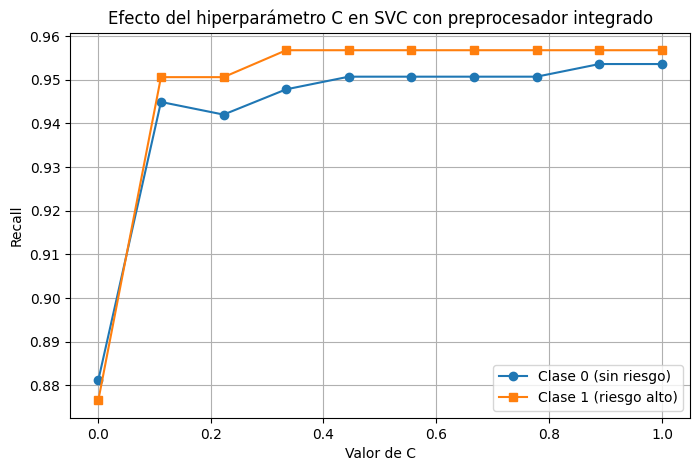

In [ ]:
plt.figure(figsize=(8,5))
plt.plot(C_values, recall_class0, marker='o', label='Clase 0 (sin riesgo)')
plt.plot(C_values, recall_class1, marker='s', label='Clase 1 (riesgo alto)')
plt.xlabel('Valor de C')
plt.ylabel('Recall')
plt.title('Efecto del hiperparámetro C en SVC con preprocesador integrado')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
recall = pd.DataFrame({
    'C': C_values,
    'Recall Clase 0': recall_class0,
    'Recall Clase 1': recall_class1
})

In [ ]:
recall

,C,Recall Clase 0,Recall Clase 1
0,0.001,0.881159,0.876543
1,0.112,0.944928,0.950617
2,0.223,0.942029,0.950617
3,0.334,0.947826,0.956790
4,0.445,0.950725,0.956790
5,0.556,0.950725,0.956790
6,0.667,0.950725,0.956790
7,0.778,0.950725,0.956790
8,0.889,0.953623,0.956790
9,1.000,0.953623,0.956790


Se observó que a partir de un valor de C ≈ 0.445 el desempeño del modelo SVC se estabiliza, obteniendo valores de recall cercanos a 0.95 para ambas clases. Incrementar el valor de C por encima de este umbral no produce mejoras adicionales en el rendimiento, por lo que se optó por el valor más bajo que garantiza un desempeño estable, reduciendo así el riesgo de sobreajuste.

In [ ]:
svc_pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('svc', SVC(C=0.445	, kernel='linear', class_weight='balanced', random_state=42))
    ])


In [ ]:
svc_pipeline.fit(X_train,y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', PowerTransformer(),
                                                  Index(['edad', 'imc', 'glu_suero', 'trig', 'col_hdl', 'insulina', 'ac_urico'], dtype='object')),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  Index(['sexo'], dtype='object'))])),
                ('svc',
                 SVC(C=0.445, class_weight='balanced', kernel='linear',
                     random_state=42))])

In [ ]:
print(classification_report(y_train,svc_pipeline.predict(X_train)))

              precision    recall  f1-score   support

           0       0.98      0.95      0.97      1349
           1       0.91      0.97      0.94       677

    accuracy                           0.96      2026
   macro avg       0.95      0.96      0.95      2026
weighted avg       0.96      0.96      0.96      2026



In [ ]:
print(classification_report(y_test,svc_pipeline.predict(X_test)))

              precision    recall  f1-score   support

           0       0.98      0.95      0.96       345
           1       0.90      0.96      0.93       162

    accuracy                           0.95       507
   macro avg       0.94      0.95      0.95       507
weighted avg       0.95      0.95      0.95       507



| Métrica               | Train | Test    | Diferencia | Estado      |
| --------------------- | ----- | ------- | ---------- | ----------- |
| **Recall Clase 1**    | 97%   | **96%** | **-1%**    | ✅ Excelente |
| **Precision Clase 1** | 91%   | **90%** | **-1%**    | ✅ Excelente |
| **F1-Score Clase 1**  | 94%   | **93%** | **-1%**    | ✅ Excelente |
| **Accuracy**          | 96%   | **95%** | **-1%**    | ✅ Excelente |


In [ ]:
from sklearn.metrics import confusion_matrix

In [ ]:
y_test_pred = svc_pipeline.predict(X_test)

In [ ]:
confusion_matrix(y_test,y_test_pred)

array([[328,  17],
       [  7, 155]])

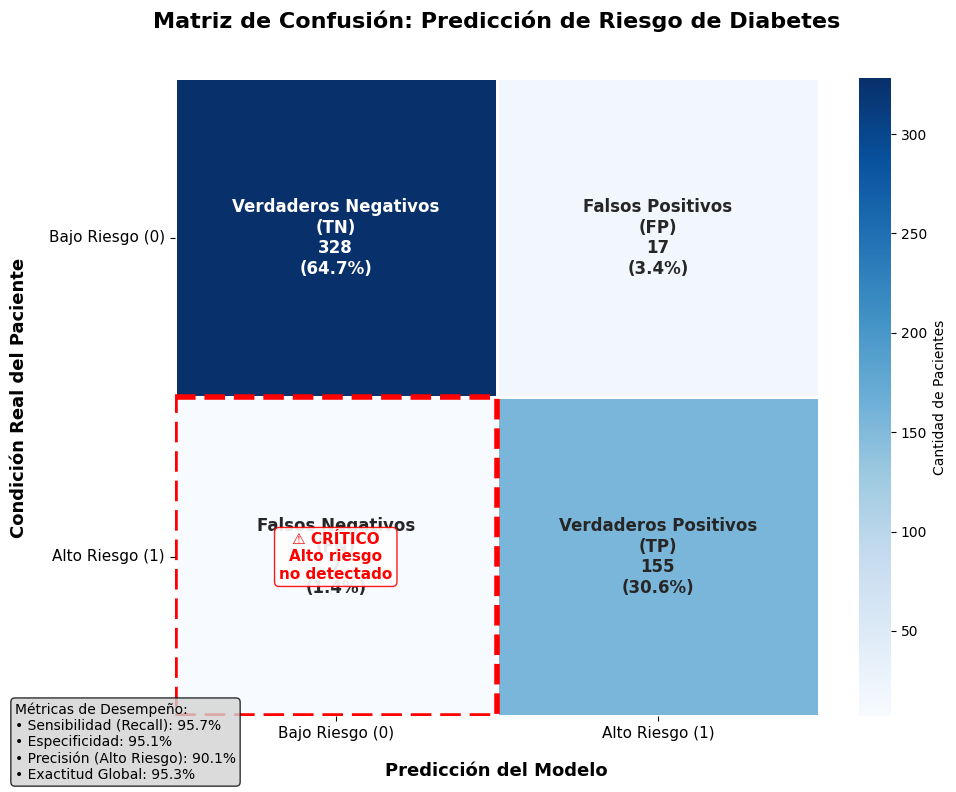

In [ ]:
import seaborn as sns
from matplotlib.patches import Rectangle


cm = confusion_matrix(y_test, y_test_pred)


labels = ['Bajo Riesgo (0)', 'Alto Riesgo (1)']
group_names = ['Verdaderos Negativos\n(TN)', 'Falsos Positivos\n(FP)',
               'Falsos Negativos\n(FN)', 'Verdaderos Positivos\n(TP)']
group_counts = [f"{value}" for value in cm.flatten()]
group_percentages = [f"{value:.1%}" for value in cm.flatten()/np.sum(cm)]


labels_cm = [f"{name}\n{count}\n({pct})"
             for name, count, pct in zip(group_names, group_counts, group_percentages)]
labels_cm = np.asarray(labels_cm).reshape(2, 2)


fig, ax = plt.subplots(figsize=(10, 8))


sns.heatmap(cm, annot=labels_cm, fmt='', cmap='Blues',
            xticklabels=labels, yticklabels=labels,
            annot_kws={'size': 12, 'weight': 'bold'},
            cbar_kws={'label': 'Cantidad de Pacientes'},
            linewidths=2, linecolor='white', ax=ax)


ax.set_title('Matriz de Confusión: Predicción de Riesgo de Diabetes\n',
             fontsize=16, fontweight='bold', pad=20)
ax.set_xlabel('Predicción del Modelo', fontsize=13, fontweight='bold', labelpad=15)
ax.set_ylabel('Condición Real del Paciente', fontsize=13, fontweight='bold', labelpad=15)


plt.xticks(rotation=0, fontsize=11)
plt.yticks(rotation=0, fontsize=11)


ax.add_patch(Rectangle((0, 1), 1, 1, fill=False, edgecolor='red', lw=4, linestyle='--'))
ax.text(0.5, 1.5, '⚠️ CRÍTICO\nAlto riesgo\nno detectado',
        ha='center', va='center', fontsize=11, color='red', fontweight='bold',
        bbox=dict(boxstyle='round,pad=0.3', facecolor='white', edgecolor='red', alpha=0.9))


metrics_text = (f"Métricas de Desempeño:\n"
                f"• Sensibilidad (Recall): {155/(155+7):.1%}\n"
                f"• Especificidad: {328/(328+17):.1%}\n"
                f"• Precisión (Alto Riesgo): {155/(155+17):.1%}\n"
                f"• Exactitud Global: {(328+155)/507:.1%}")

plt.figtext(0.02, 0.02, metrics_text, fontsize=10,
            bbox=dict(boxstyle='round', facecolor='lightgray', alpha=0.8))

plt.tight_layout()

plt.savefig("confusion_matrix_diabetes.png", dpi=120, bbox_inches="tight")
plt.show()

### **Validación Cruzada**

In [ ]:
from sklearn.model_selection import cross_val_score

In [ ]:
cross_val_score(svc_pipeline,X_test,y_test,scoring="recall_weighted",cv = 5).mean()

np.float64(0.9328479906814211)

In [ ]:
cross_val_score(svc_pipeline,X_test,y_test,scoring="recall",cv = 5).mean()

np.float64(0.9378787878787879)

Se evaluó el modelo mediante validación cruzada utilizando las métricas **recall** y **recall_weighted**. El recall permite medir la capacidad del modelo para identificar correctamente a los pacientes con riesgo alto de diabetes, siendo especialmente relevante en un contexto clínico. Por otro lado, el recall_weighted pondera el desempeño de cada clase según su proporción en el conjunto de datos, ofreciendo una visión global del rendimiento. Los resultados consistentes y elevados en ambas métricas indican que el modelo mantiene un buen equilibrio entre clases, a pesar del desbalance presente en los datos.

## **Interpretación clínica de las variables del modelo**

In [ ]:
from sklearn.inspection import permutation_importance

In [ ]:
r = permutation_importance(
    svc_pipeline,
    X_train,
    y_train,
    n_repeats=20,
    scoring="recall",
    random_state=42
)

importances = pd.DataFrame({
    "variable": X_train.columns,
    "importance": r.importances_mean
}).sort_values("importance", ascending=False)

In [ ]:
importances

,variable,importance
3,glu_suero,0.602290
1,edad,0.000812
0,sexo,0.000739
5,col_hdl,0.000443
7,ac_urico,0.000148
6,insulina,0.000148
2,imc,0.000000
4,trig,0.000000




La variable con mayor importancia dentro del modelo fue la concentración de **glucosa sérica** (glu_suero), lo cual resulta clínicamente esperado y coherente. La glucosa sérica es el principal predictor del riesgo de diabetes, ya que refleja de manera directa el estado glucémico actual del paciente y permite capturar tanto estados de prediabetes como casos de diabetes no diagnosticada. Por ello, su elevada contribución al modelo es consistente con la fisiopatología de la enfermedad.

La **edad** mostró una contribución menor pero relevante, lo cual es clínicamente correcto, dado que el riesgo de desarrollar diabetes mellitus tipo 2 aumenta progresivamente con el envejecimiento. Este fenómeno se asocia a una disminución gradual de la función de las células **$β$** pancreáticas, así como a un incremento en la resistencia a la insulina relacionado con la edad.

La variable **sexo** también aportó información al modelo, aunque con un peso reducido. Esto es esperable, ya que existen diferencias hormonales, en la distribución de la grasa corporal y en el riesgo cardiometabólico entre hombres y mujeres. Si bien no suele ser una variable dominante, su contribución es consistente con la evidencia clínica.

El **colesterol HDL** (col_hdl) emergió como una variable relevante, lo cual refuerza la validez clínica del modelo. Niveles bajos de HDL se asocian estrechamente con resistencia a la insulina y forman parte del síndrome metabólico, por lo que su inclusión como predictor aporta información metabólica de valor.

El **ácido úrico** mostró una contribución significativa, lo cual resulta especialmente interesante desde el punto de vista clínico. Esta variable se ha asociado con resistencia a la insulina, inflamación crónica y mayor riesgo cardiometabólico. Su presencia dentro del modelo añade solidez clínica, dado que suele ser ignorada en modelos más simplificados.

La **insulina** aportó información relevante al modelo al capturar estados de hiperinsulinemia y permitir la identificación de etapas tempranas de resistencia a la insulina. No obstante, debe considerarse la posible colinealidad con la glucosa sérica, así como la variabilidad en su medición, que no siempre es estandarizada en todos los contextos clínicos.

Finalmente, el **índice de masa corporal (IMC)** y los **triglicéridos** presentaron una importancia nula dentro del modelo, aun después de aplicar transformaciones de potencia. Esto no necesariamente indica un error, sino que sugiere que estas variables no aportan información incremental relevante en presencia de otros marcadores metabólicos más directos, como la glucosa sérica, la insulina y el colesterol HDL. En particular, aunque el IMC es ampliamente utilizado como indicador de riesgo cardiometabólico, presenta limitaciones importantes al no discriminar entre masa grasa y masa muscular. Por ello, cuando se dispone de variables bioquímicas directamente relacionadas con la resistencia a la insulina, el IMC tiende a perder relevancia predictiva, lo cual se refleja en su baja importancia dentro del modelo.

## **Nuevas  Predicciones**

In [ ]:
X_train.columns

Index(['sexo', 'edad', 'imc', 'glu_suero', 'trig', 'col_hdl', 'insulina',
       'ac_urico'],
      dtype='object')

In [ ]:


paciente_alto_riesgo = {
    'sexo': 'Hombre',
    'edad': 57,
    'imc': 33.8,
    'glu_suero': 182,
    'trig': 285,
    'col_hdl': 34,
    'insulina': 27,
    'ac_urico': 7.6
}




paciente_alto_riesgo_df = pd.DataFrame([paciente_alto_riesgo])

In [ ]:
paciente_bajo_riesgo = {
    'sexo': 'Mujer',           # 0 = mujer
    'edad': 29,
    'imc': 22.3,
    'glu_suero': 92,
    'trig': 95,
    'col_hdl': 62,
    'insulina': 7.8,
    'ac_urico': 4.1
}

paciente_bajo_riesgo_df = pd.DataFrame([paciente_bajo_riesgo])

In [ ]:
def predict(paciente):
  y_pred = svc_pipeline.predict(paciente)
  return np.where(y_pred == 1, "Riesgo Alto", "Riesgo Bajo")

In [ ]:
predict(paciente_bajo_riesgo_df)

array(['Riesgo Bajo'], dtype='<U11')

In [ ]:
predict(paciente_alto_riesgo_df)

array(['Riesgo Alto'], dtype='<U11')

## **Guardar Modelo**

In [ ]:
import joblib

In [ ]:
joblib.dump(svc_pipeline,'/content/drive/MyDrive/modelo/svc_diabetes.pkl')

['/content/drive/MyDrive/modelo/svc_diabetes.pkl']